# Implementation of parallelized K-Means 

Parallel version of readFile, assign2cluster, initialize_centroids, k-means and plot_centroids functions. The aim of this assignment is to implement a parallel version of the K-Means clustering algorithm in Spark with Python to work in a highly parallelizable setting. The experiments will be carried out with the MNIST dataset.

### Preprocessing

The `parallelReadFile` function uses PySpark to read a CSV file into an RDD, removing the header and the first column (label). It achieves this by filtering out the header row and converting the remaining rows into lists of floats, excluding the label. This function enables efficient, distributed processing of large datasets in Spark environments, returning an RDD of data points suitable for further analysis or machine learning tasks.

In [1]:
from pyspark import SparkContext

def is_header(line):
    # Check if the line is a header by a known header feature (e.g., 'label')
    if line.startswith("label"):
        return []
    else:
        return [line]


def convert_to_float(line):
    # Convert all elements except the first one (label) to float and return as a list
    return [float(x) for x in line.split(",")[1:]]


def parallelReadFile(filename):
    """
    Reads a CSV file into an RDD, dropping the first row (header) and the first column (label).

    Parameters:
    filename : str
        The path to the CSV file.

    Returns:
    RDD
        An RDD of data points, where each data point is represented as a list of floats, excluding the label.
    """

    # Get an existing SparkContext or create a new one
    sc = SparkContext.getOrCreate()

    # Read the file into an RDD
    data = sc.textFile(filename)

    # Filter out the header and convert the rest of the lines to float arrays
    processed_data = data.flatMap(is_header).map(convert_to_float)

    return processed_data


### Assign to Cluster

The `parallelAssign2cluster` function in Python computes the Euclidean distance between a given data point `x` and each centroid in a list of centroids, identifying the index of the closest centroid. It returns a tuple containing the index of the closest centroid and the data point `x` (converted to a NumPy array) along with the count `1`, facilitating further aggregation in clustering algorithms like K-means. This function is designed for distributed computation in a PySpark environment.

In [2]:
import numpy as np

def parallelAssign2cluster(x, centroids):
    min_distance = np.inf  # Initialize the minimum distance to infinity
    closest_centroid_index = -1  # Initialize the index of the closest centroid

    # Iterate over each centroid to compute the Euclidean distance to the data point x
    for j, centroid in enumerate(centroids):
        centroid = np.array(centroid)  # Ensure centroid is a NumPy array
        distance = np.sqrt(np.sum((x - centroid) ** 2))

        # If the computed distance is less than the current minimum, update the minimum and index
        if distance < min_distance:
            min_distance = distance
            closest_centroid_index = j

    return (closest_centroid_index, (np.array(x), 1))


### K-Means

The `parallelKMeans` function implements the K-Means clustering algorithm in a distributed manner using PySpark. It initializes centroids randomly, iterates over a specified number of iterations, and in each iteration, assigns data points in RDD `X` to the nearest centroid, then updates the centroids based on the mean of the assigned points. The function handles cases where some centroids have no assigned points by reinitializing them, ensuring that the number of centroids remains constant throughout the process. This implementation is suited for large-scale datasets, leveraging Spark's distributed computing capabilities.

In [3]:
import os

def initialize_centroids(data, K):
    """
    Initialize K centroids from a standard normal distribution.

    :param data: Pandas DataFrame, the dataset from which feature dimensions are determined.
    :param K: int, the number of centroids to initialize.
    :return: numpy array, initialized centroids.
    """
    num_features = len(data.first())

    # Initialize centroids
    centroids = np.random.randn(K, num_features)

    return centroids


def averageCentroid(x):
    return x[1][0] / x[1][1]


def parallelKMeans(X, K, n_iter):
    sc = SparkContext.getOrCreate()

    # Initialize centroids
    centroids = initialize_centroids(X, K)
    for _ in range(n_iter):
        print("Iteration: ", _)
        # Assign clusters
        broadcast_centroids = sc.broadcast(centroids)
        centroids_assigned = X.map(
            lambda x: parallelAssign2cluster(x, broadcast_centroids.value)
        )
        # Update centroids
        centroids = (
            centroids_assigned.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
            .map(averageCentroid)
            .collect()
        )

        if len(centroids) < K:
            centroids = np.concatenate(
                (centroids, initialize_centroids(X, K - len(centroids)))
            )

    return centroids


### Testing

This script sets up a PySpark environment and runs a parallel K-Means clustering algorithm on MNIST dataset images. It reads the data using `parallelReadFile`, caches it for performance optimization, and performs clustering with `parallelKMeans` to identify 10 centroids. Finally, it visualizes these centroids as images using `plot_centroids`, displaying each centroid reshaped to the original image dimensions. The script integrates various components, including PySpark setup, data processing, clustering, and visualization within a Python executable script.

In [4]:
import sys
import matplotlib.pyplot as plt

def plot_centroids(centroids, image_size=(28, 28)):
    """
    Plot each centroid as an image.

    :param centroids: numpy array, centroids with each row representing a centroid.
    :param image_size: tuple, the (height, width) of the images represented by the centroids.
    """
    for i, centroid in enumerate(centroids):
        # Reshape the centroid to the original image dimensions
        image = centroid.reshape(image_size)

        # Plot the image
        plt.figure()
        plt.imshow(image, cmap="gray")
        plt.title(f"Centroid {i+1}")
        plt.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/17 18:26:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/17 18:26:12 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


23/12/17 18:26:20 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


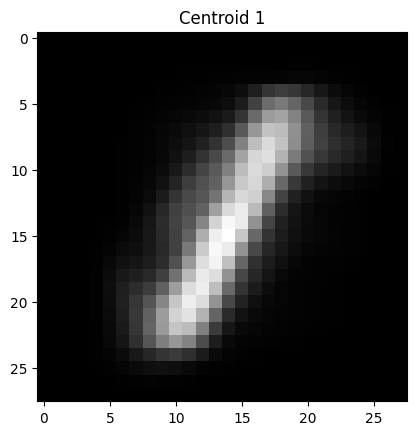

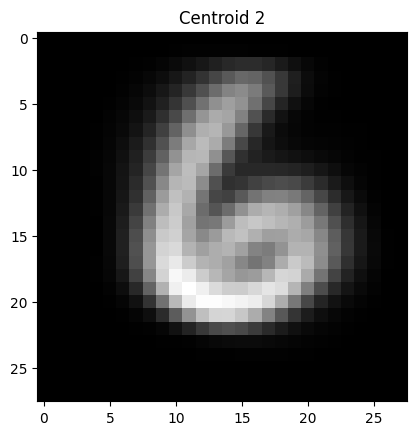

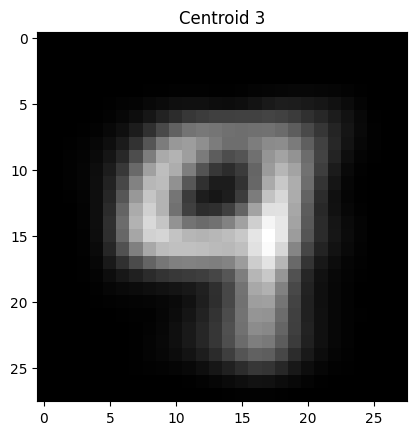

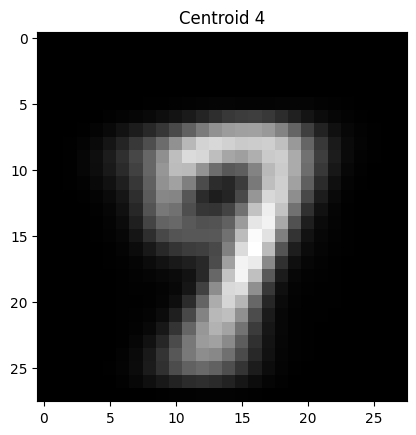

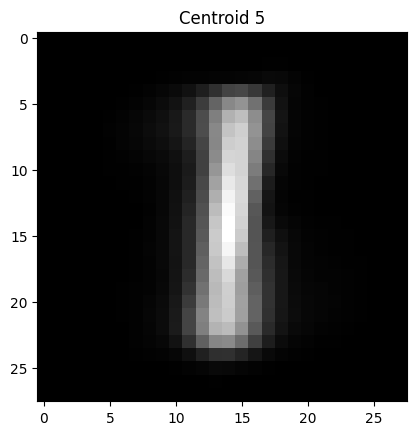

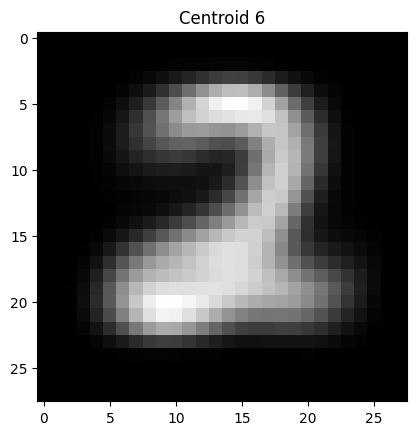

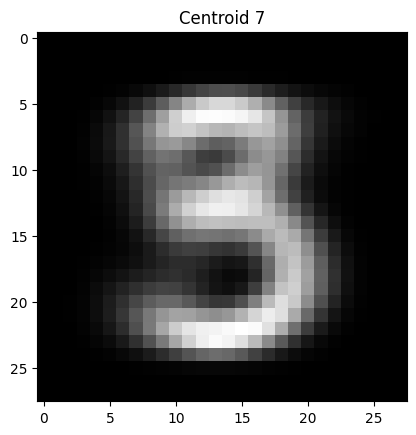

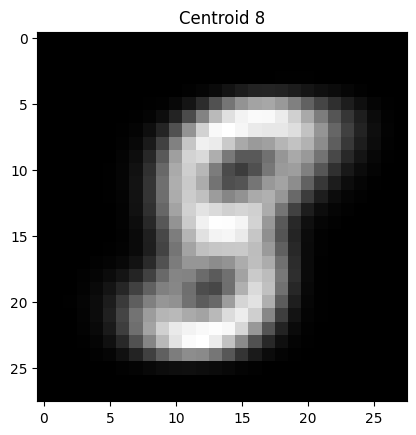

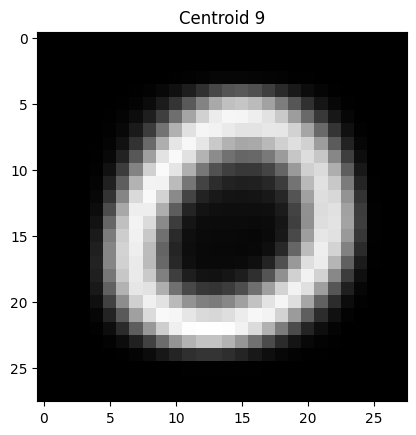

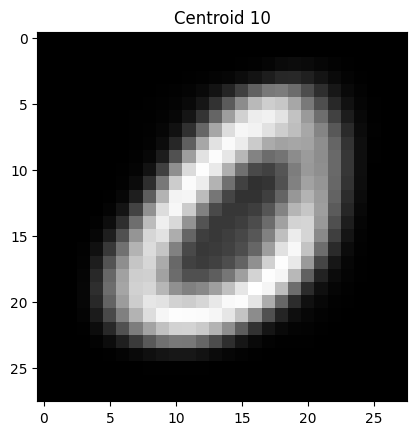

23/12/17 18:29:06 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


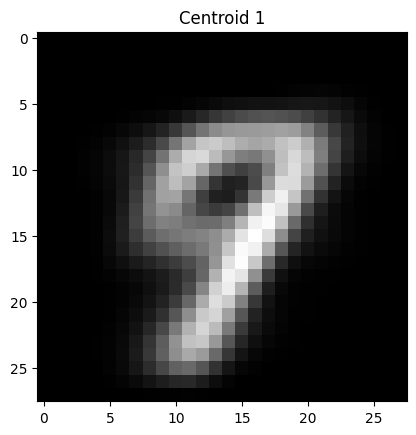

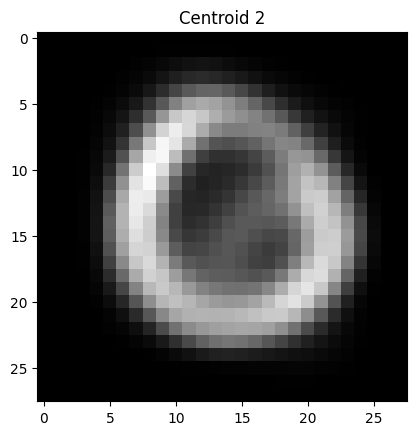

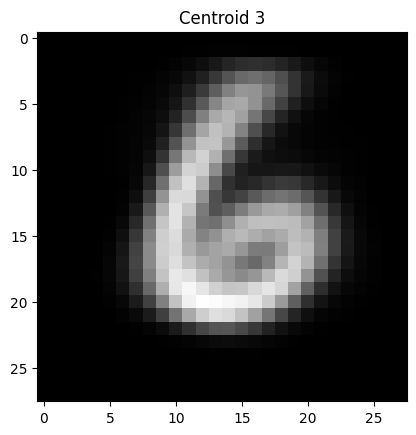

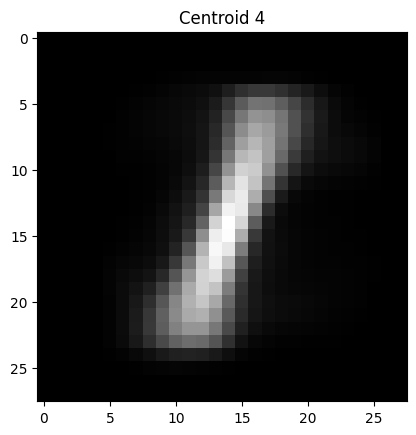

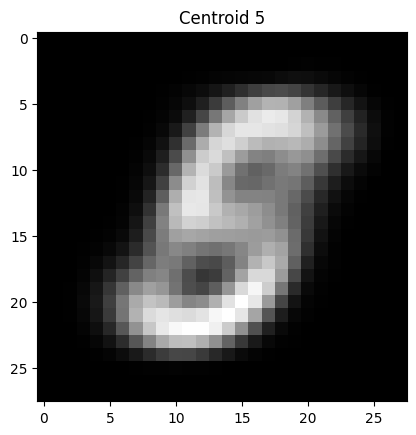

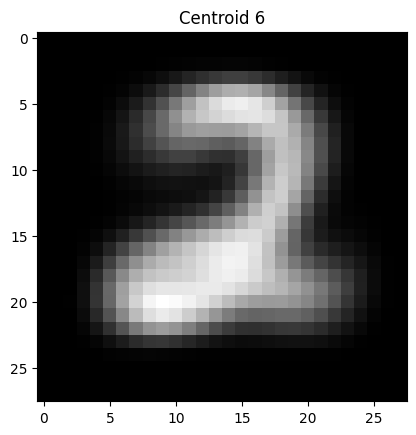

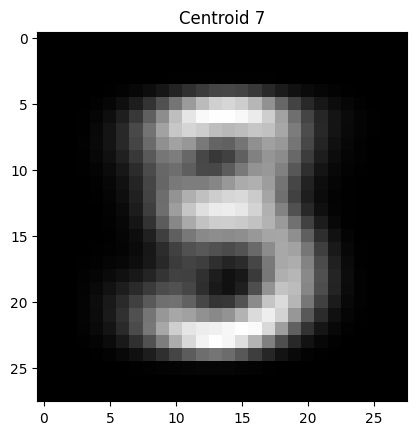

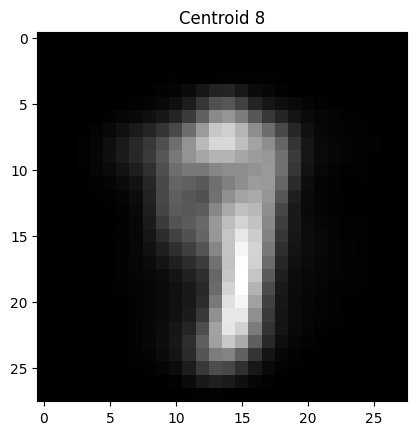

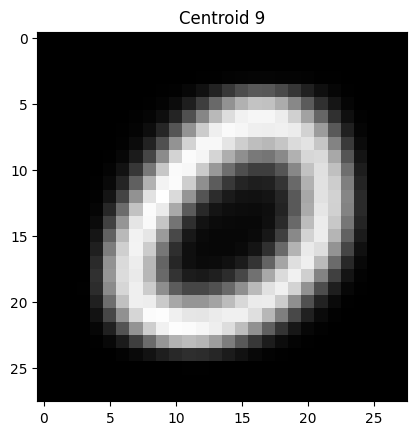

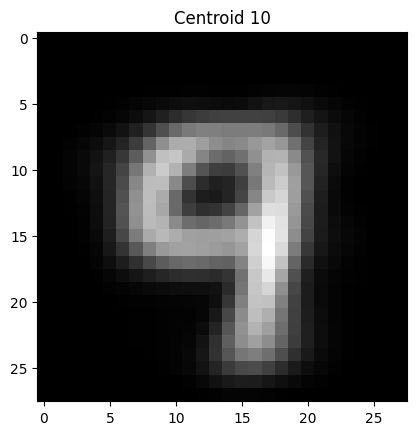

23/12/17 18:30:38 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


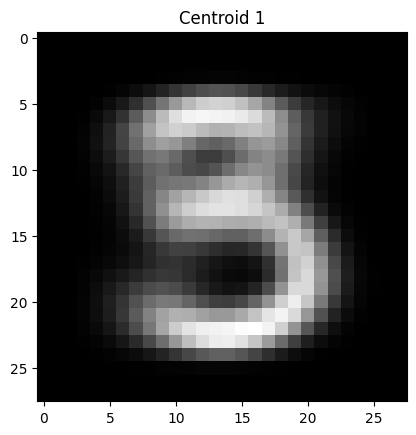

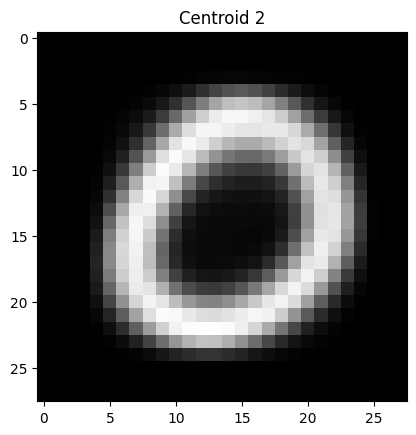

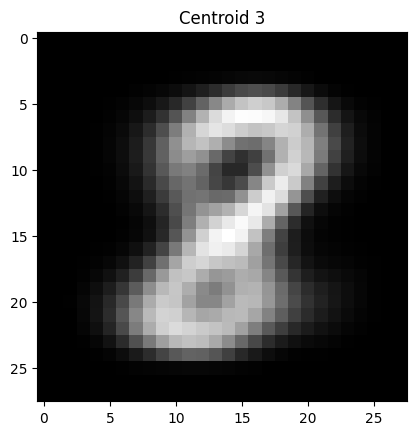

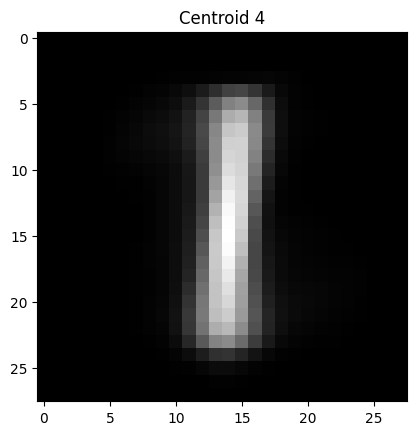

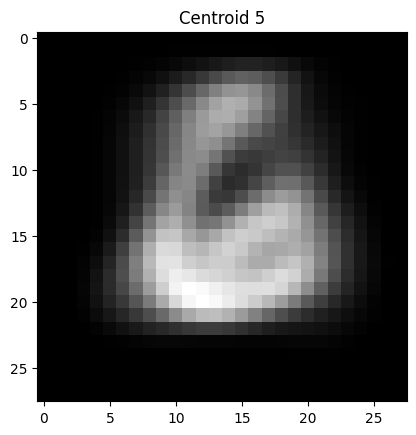

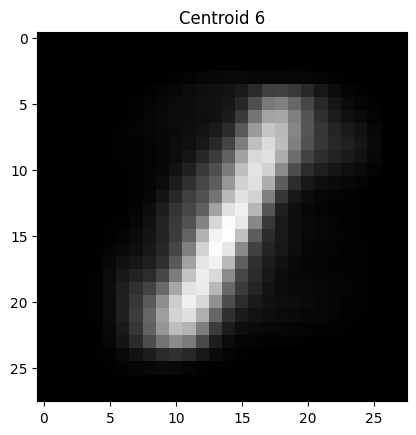

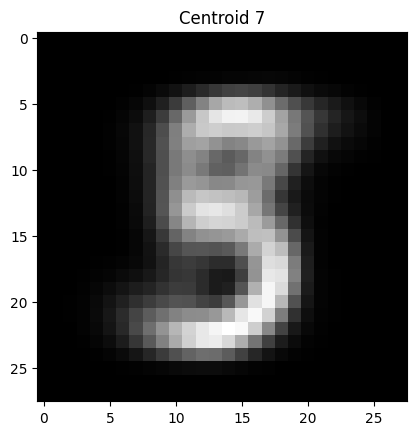

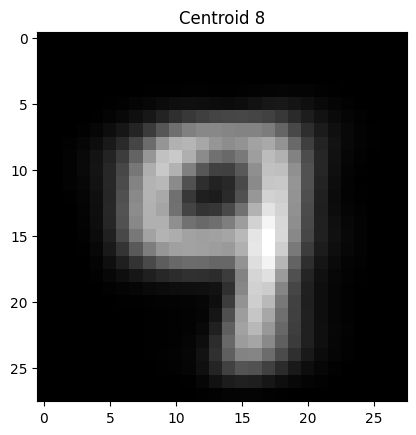

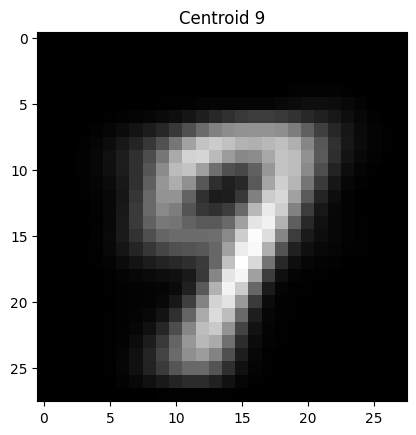

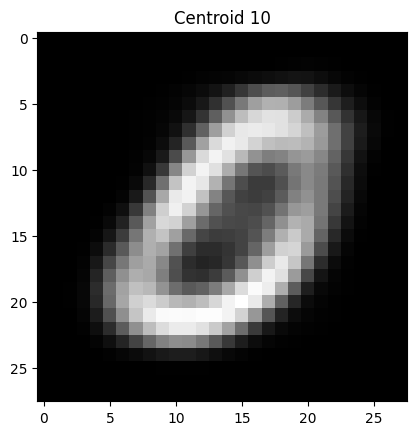

23/12/17 18:32:03 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


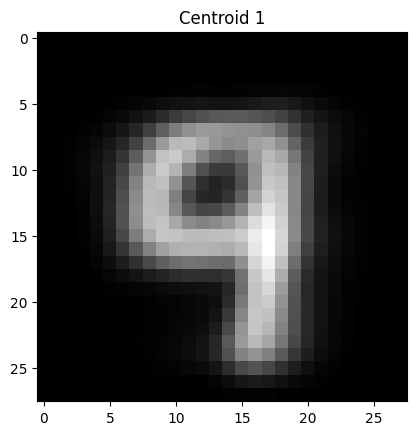

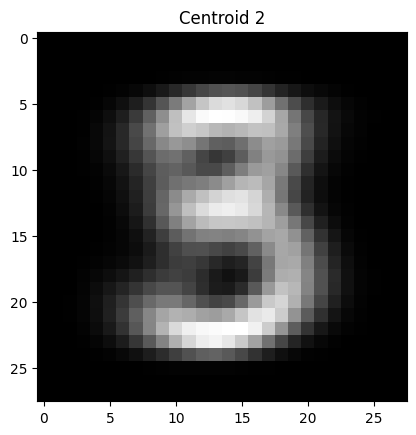

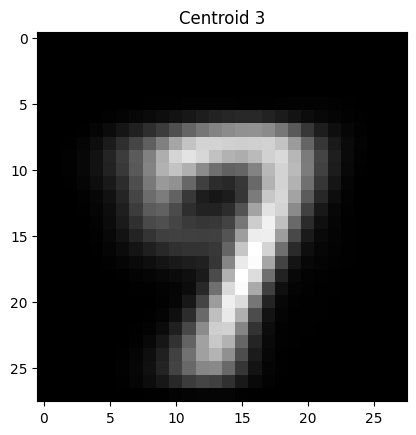

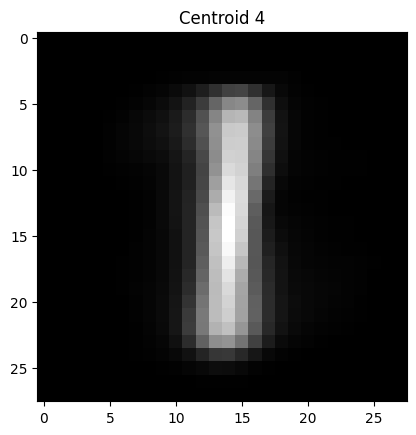

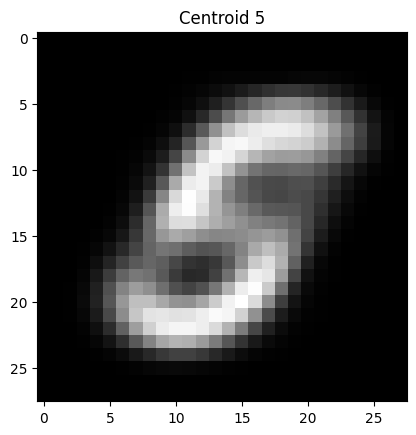

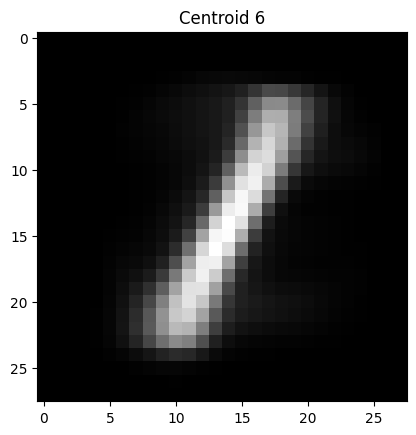

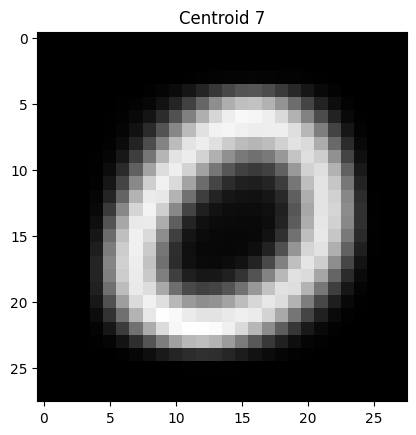

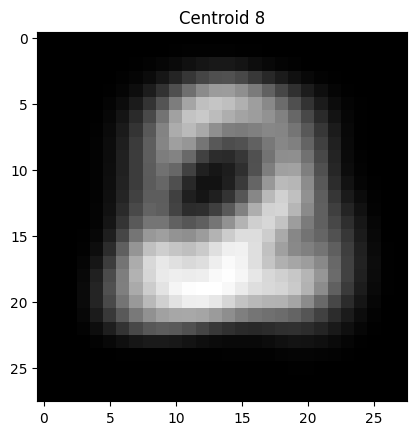

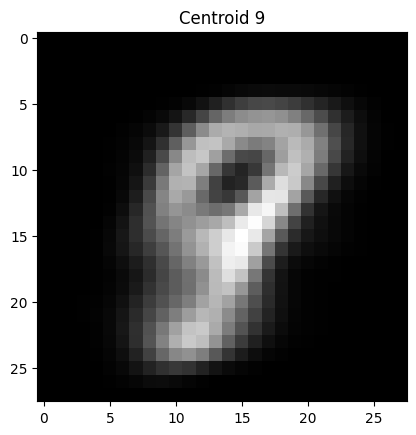

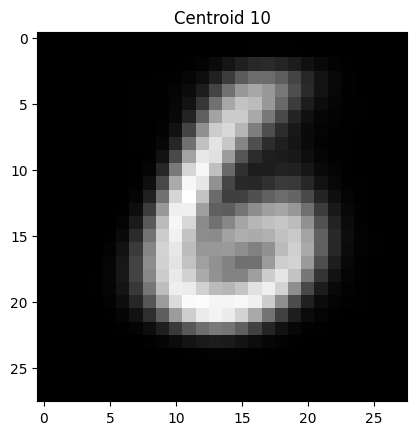

23/12/17 18:32:51 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


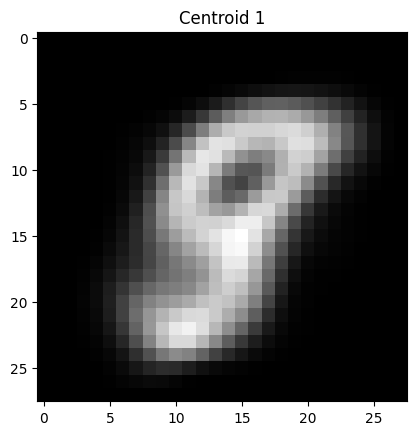

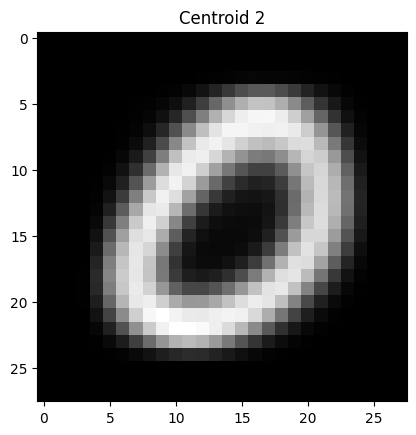

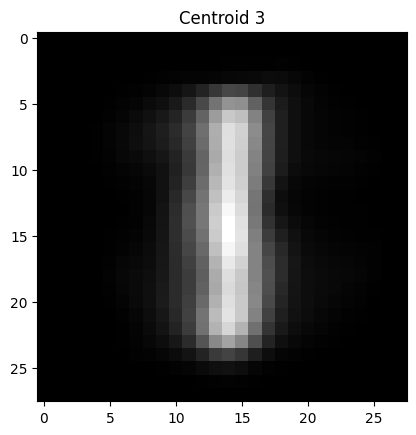

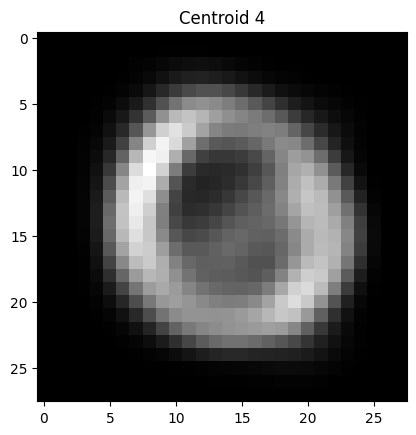

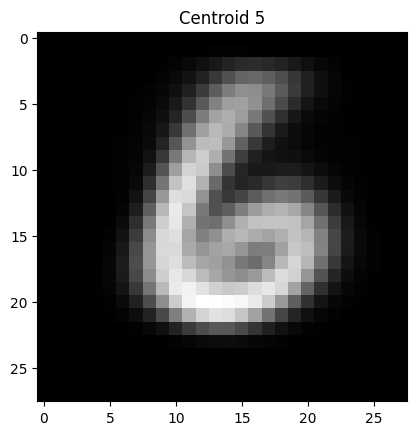

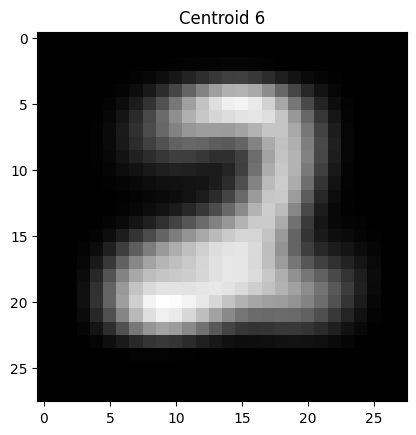

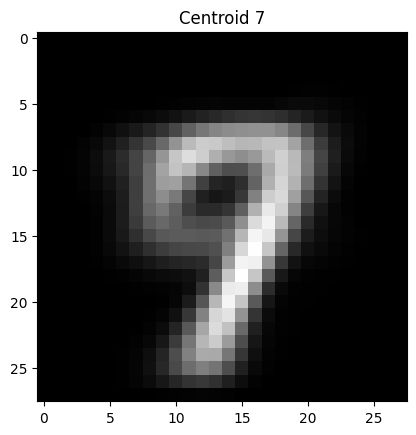

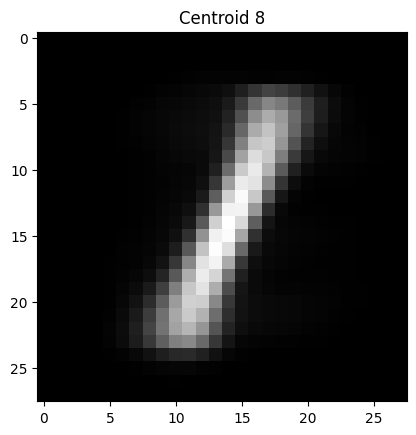

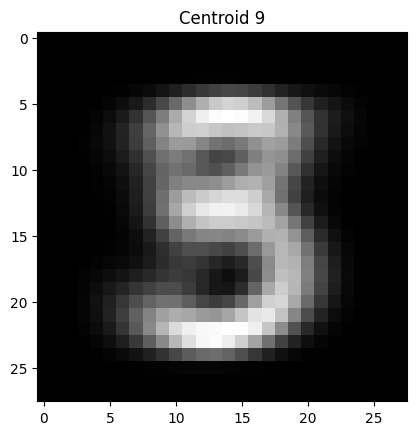

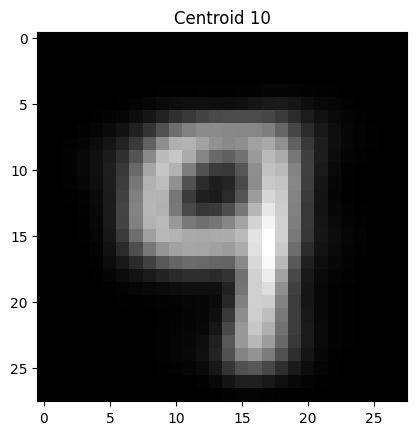

23/12/17 18:33:39 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


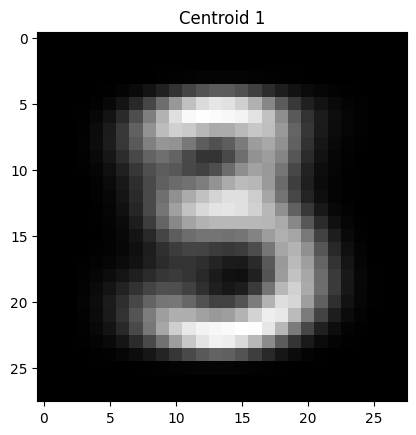

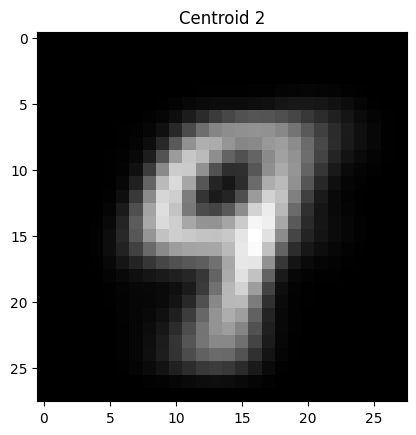

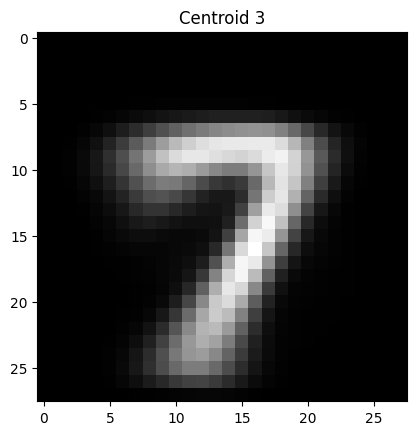

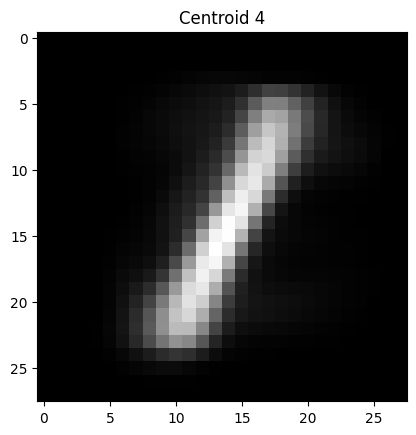

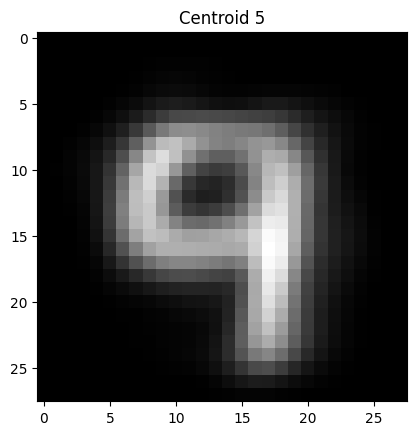

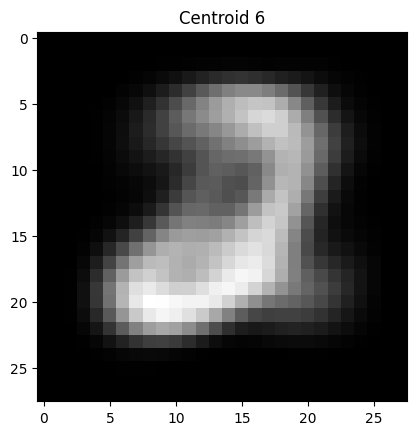

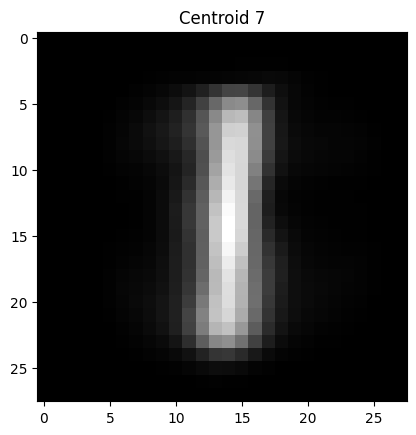

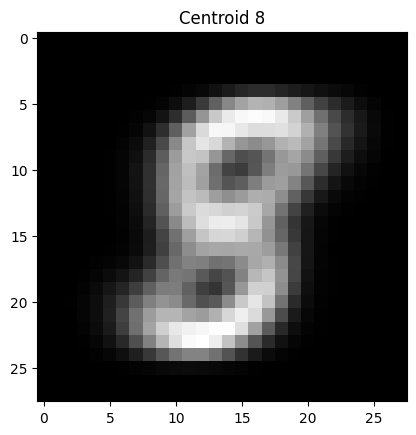

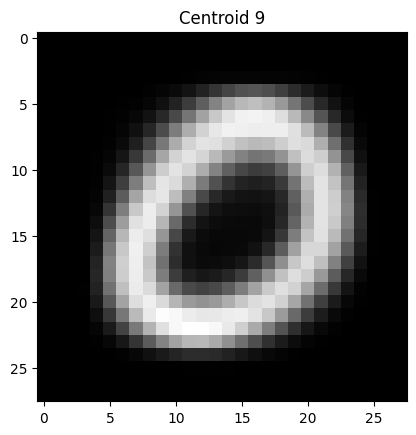

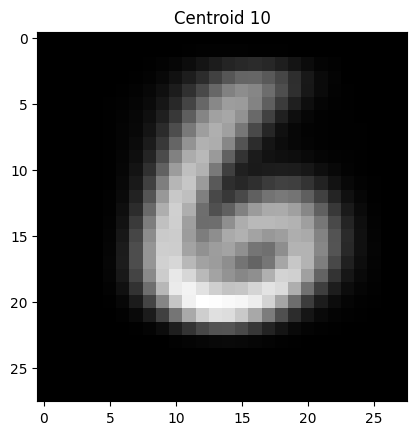

23/12/17 18:34:29 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


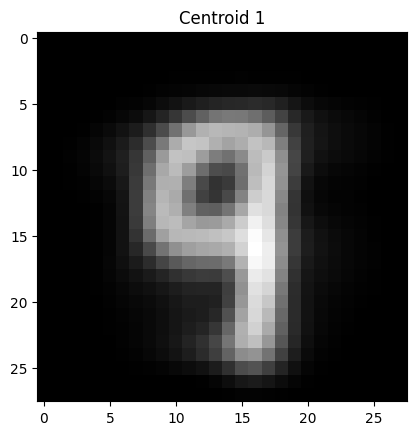

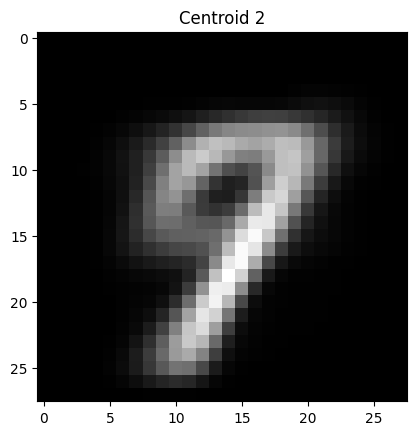

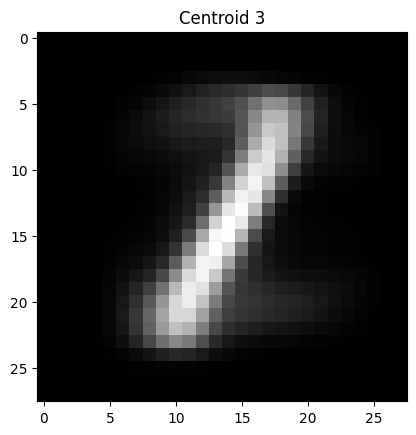

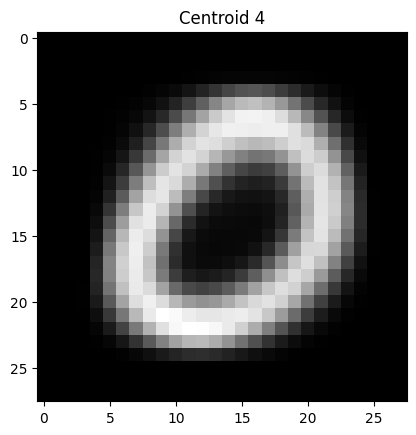

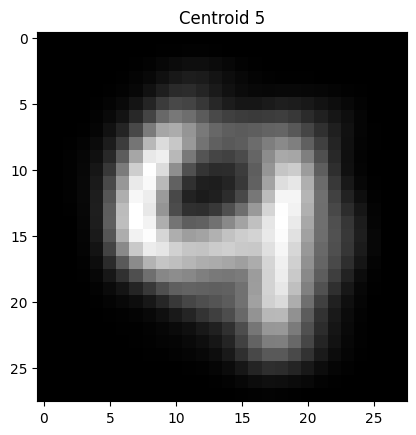

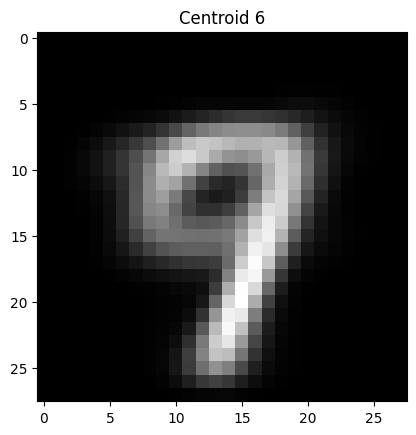

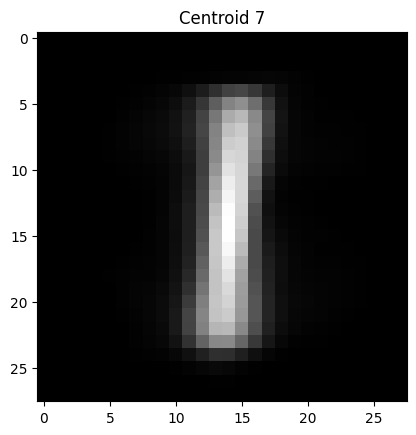

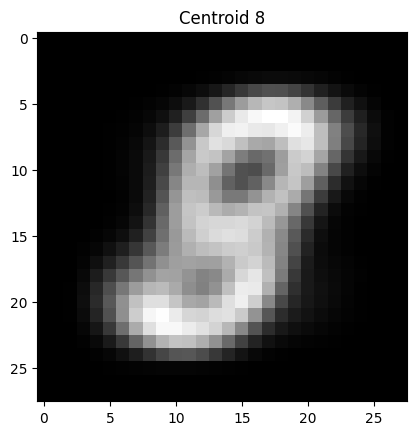

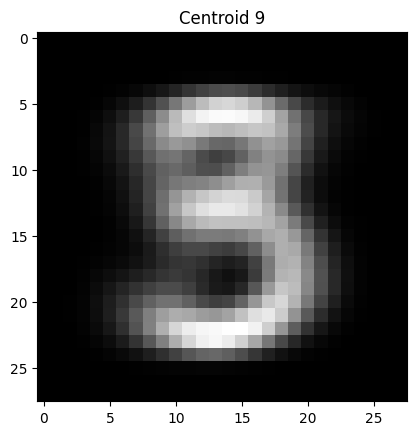

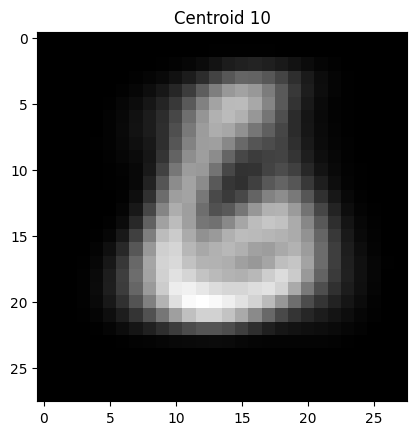

23/12/17 18:35:18 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


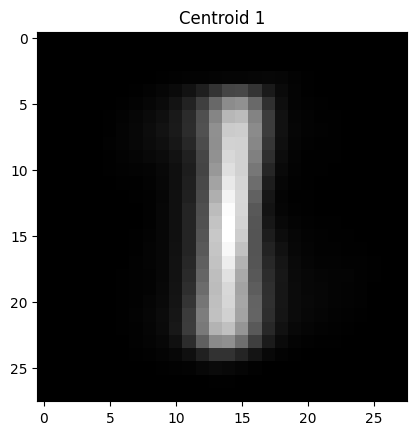

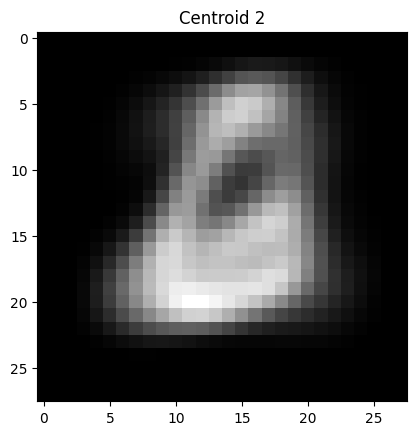

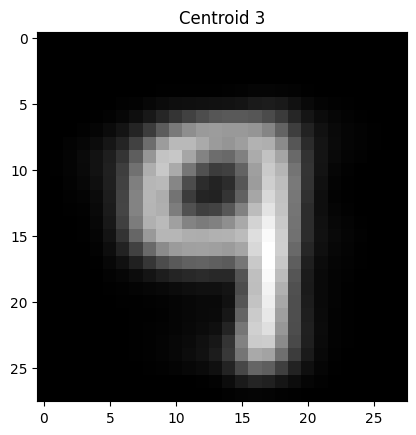

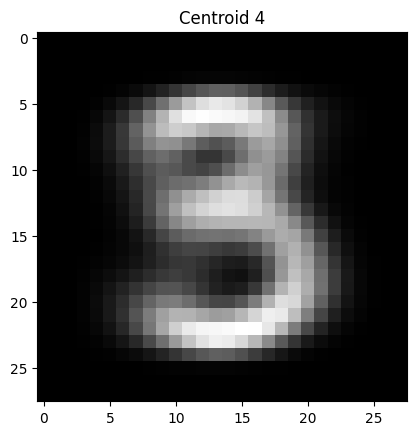

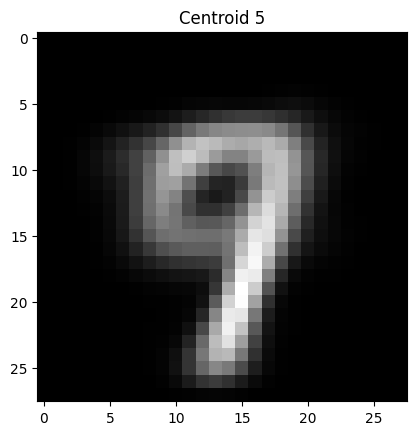

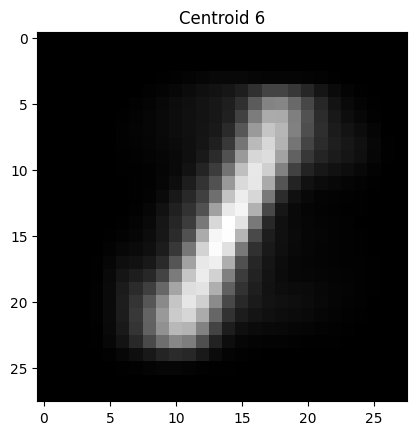

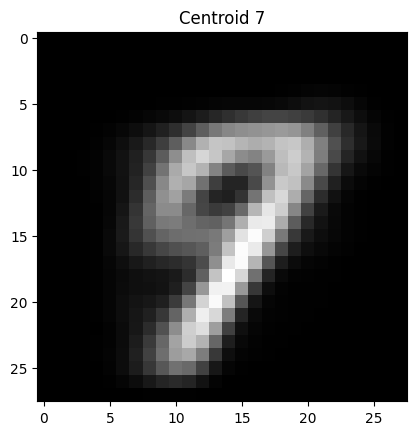

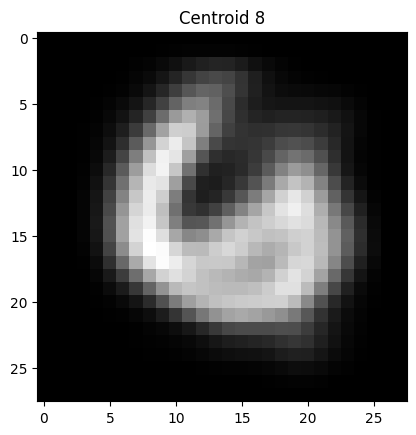

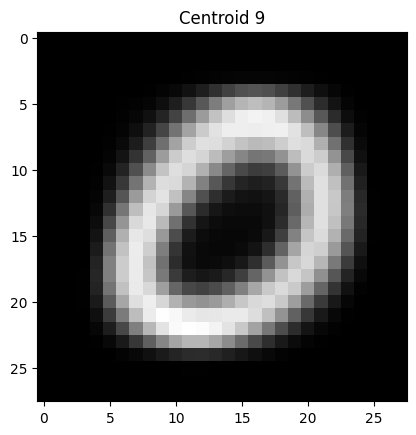

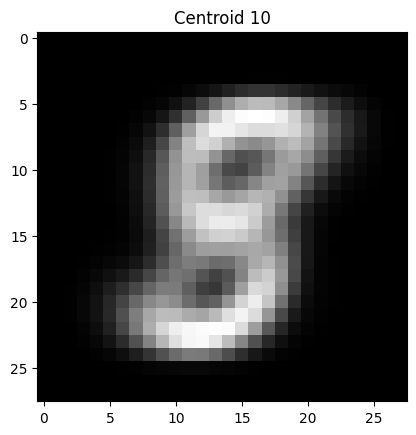

23/12/17 18:36:07 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


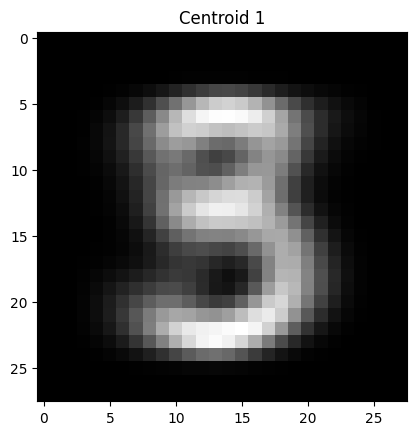

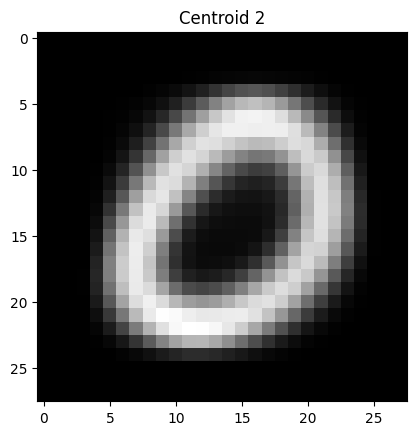

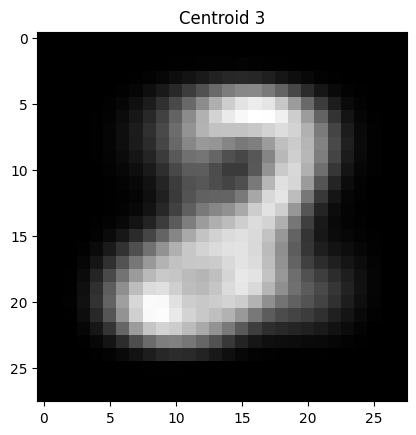

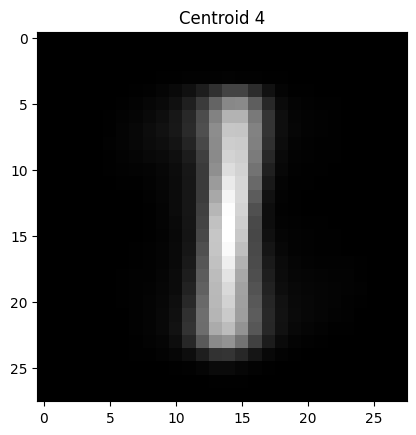

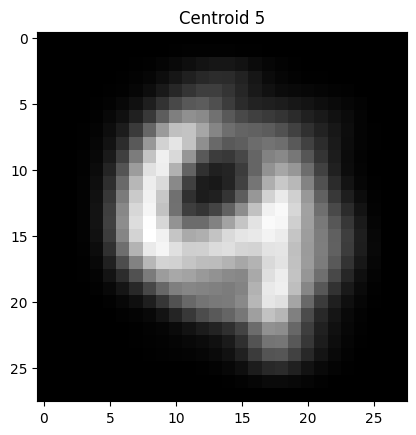

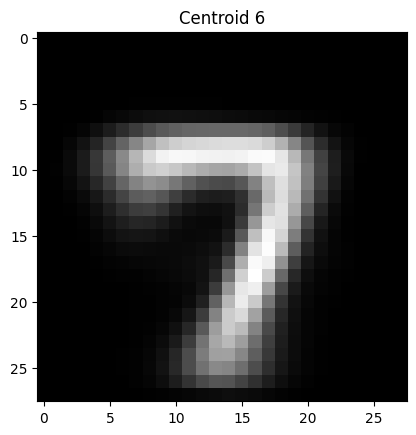

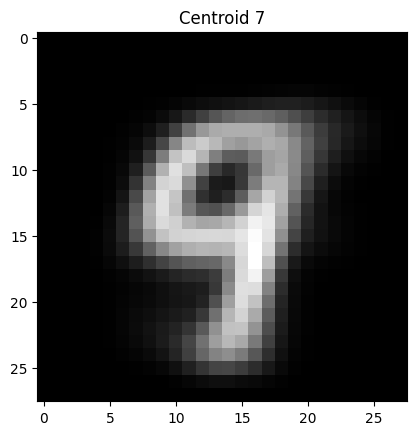

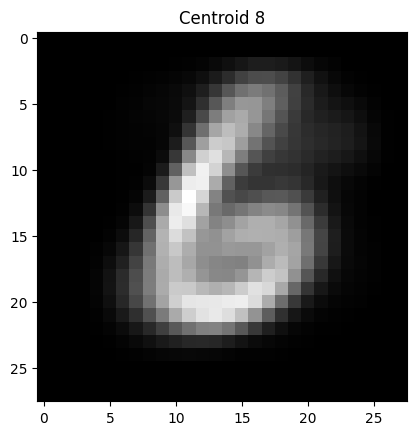

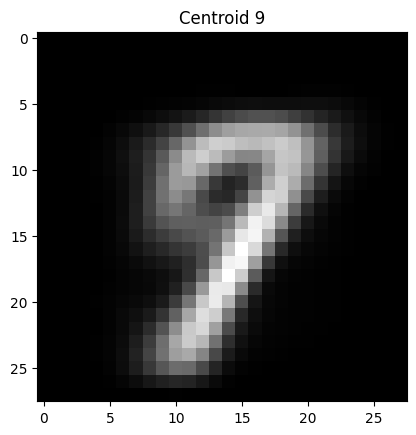

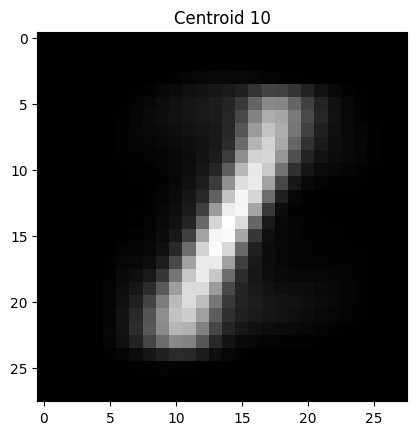

23/12/17 18:36:55 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


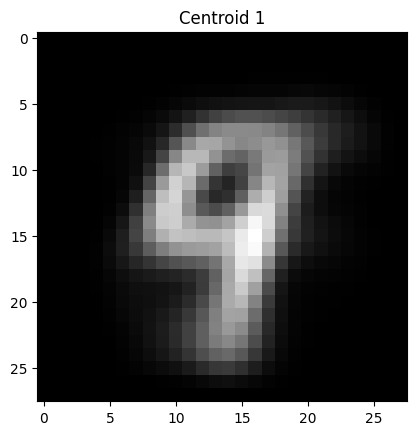

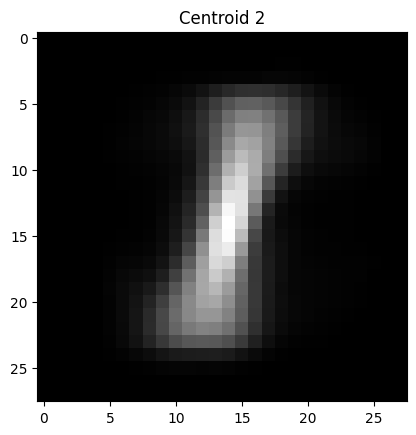

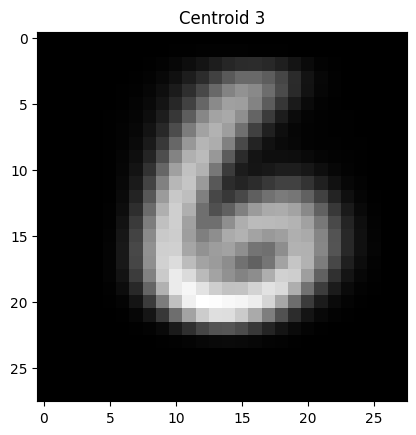

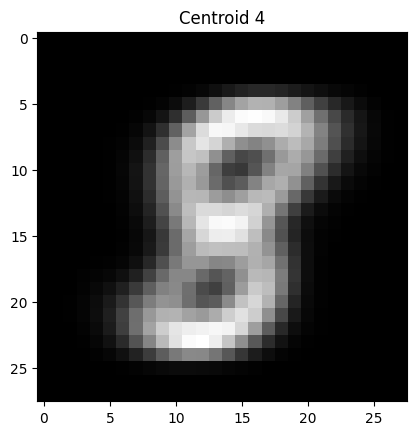

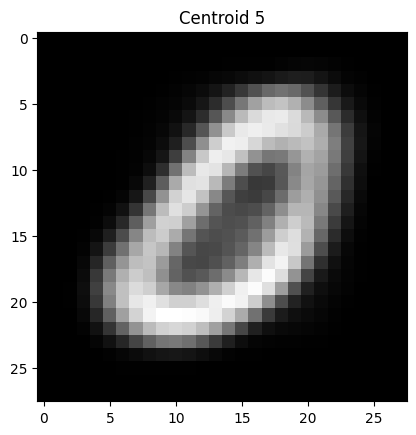

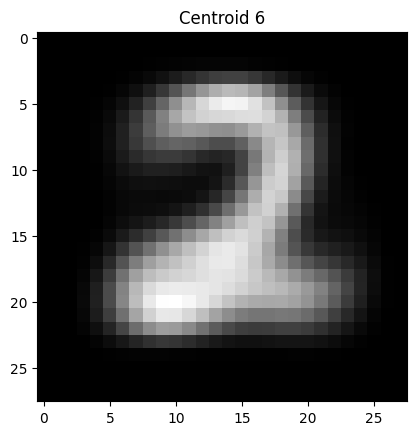

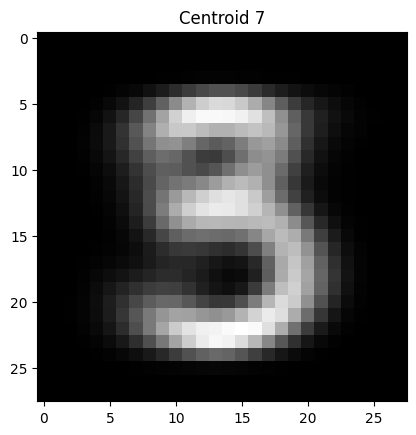

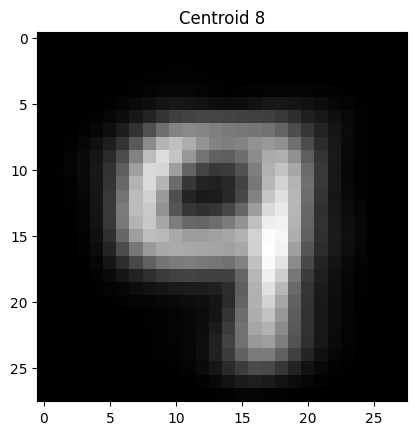

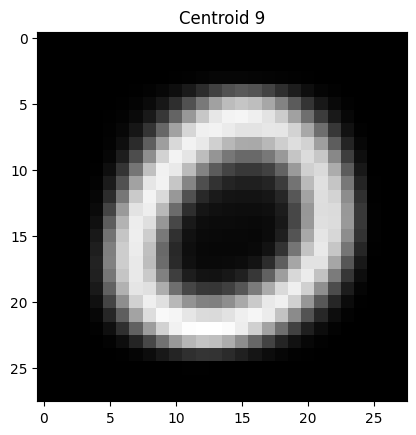

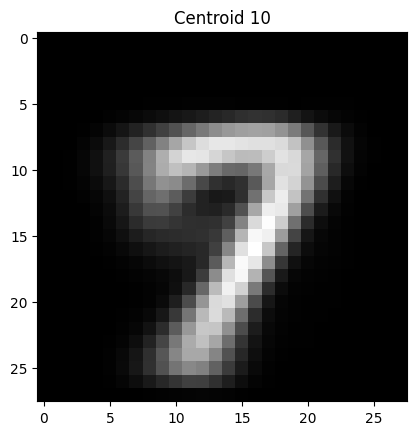

23/12/17 18:37:44 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


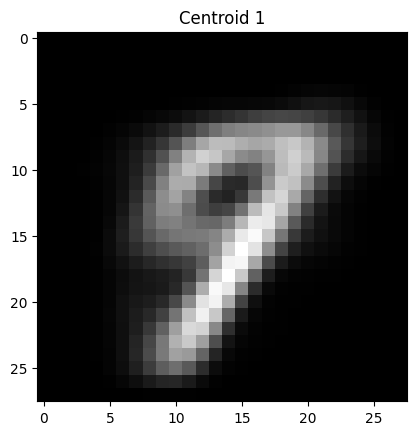

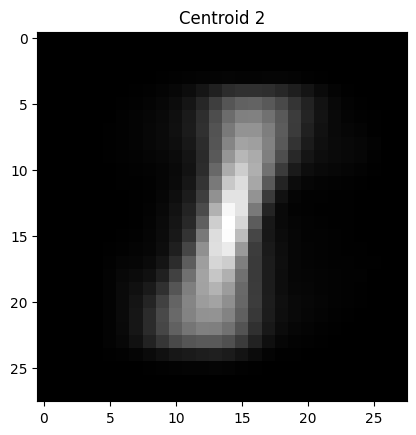

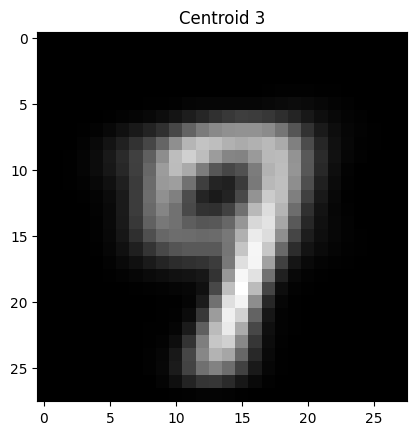

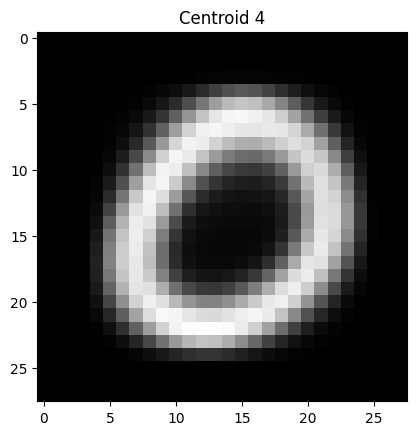

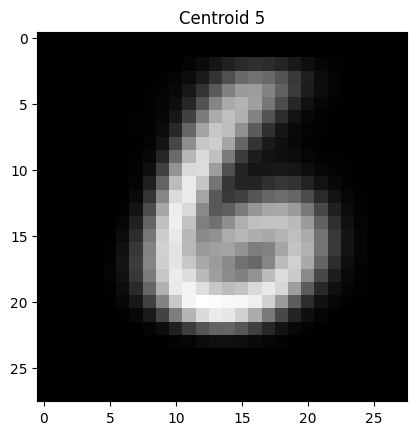

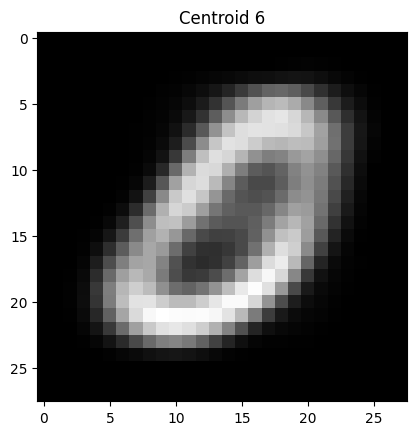

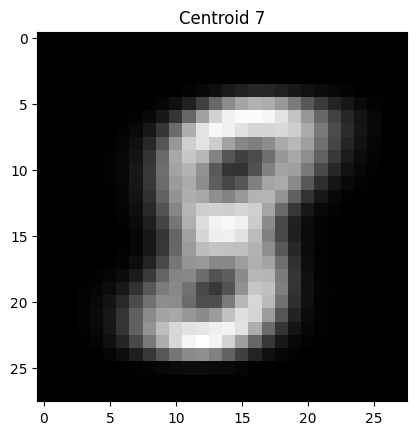

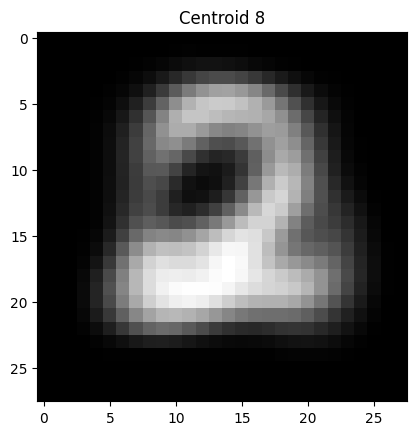

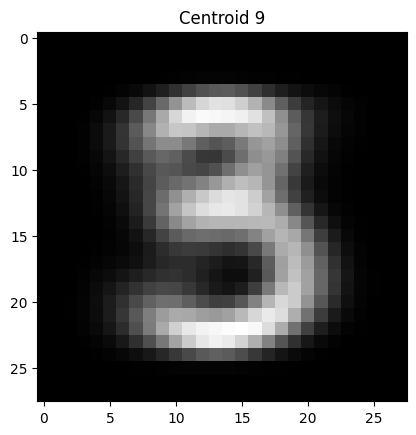

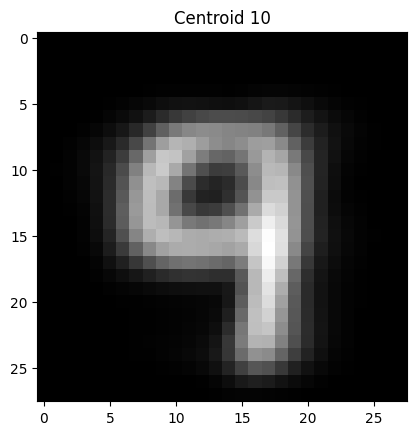

23/12/17 18:38:34 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


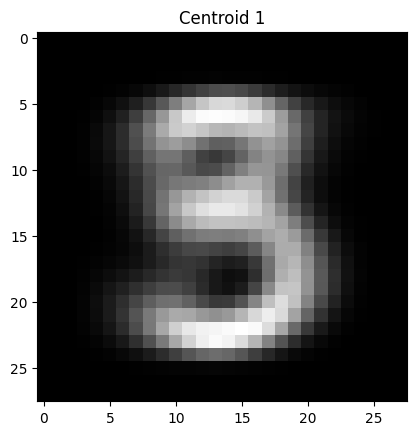

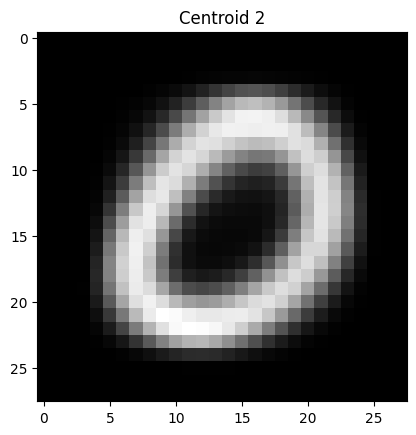

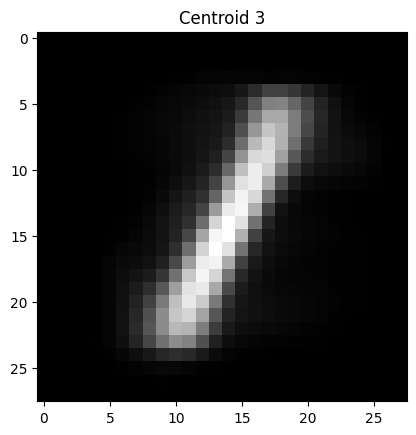

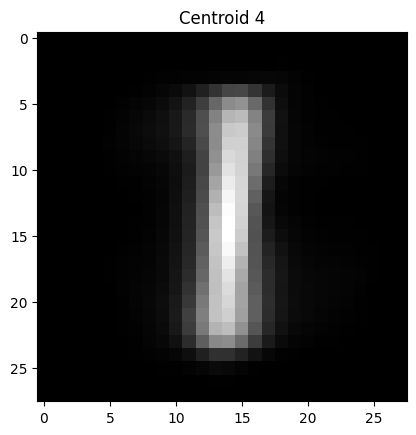

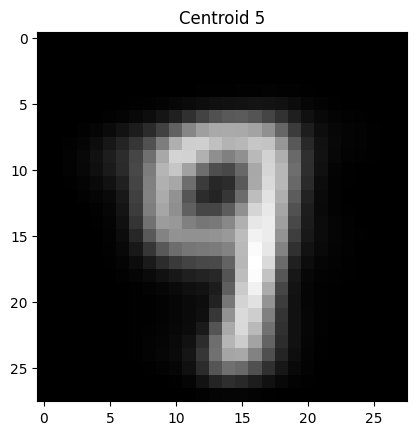

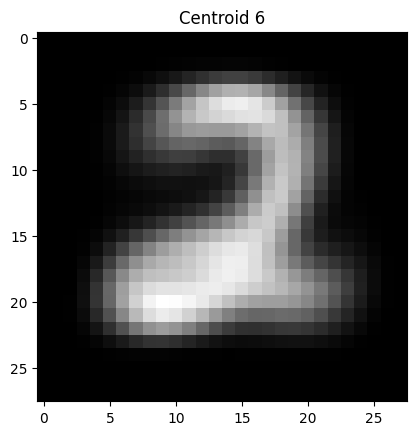

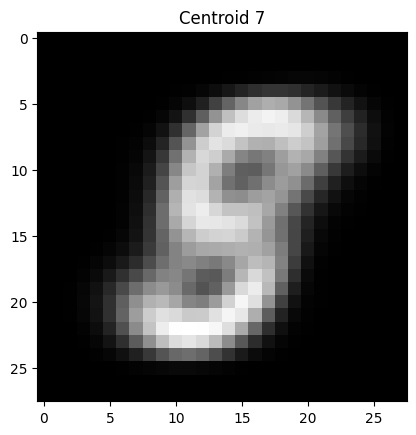

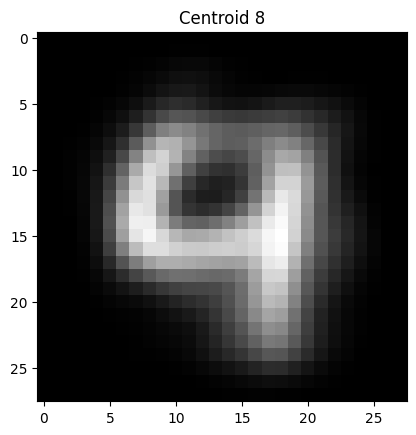

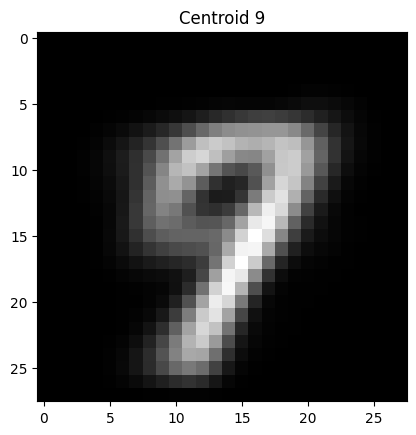

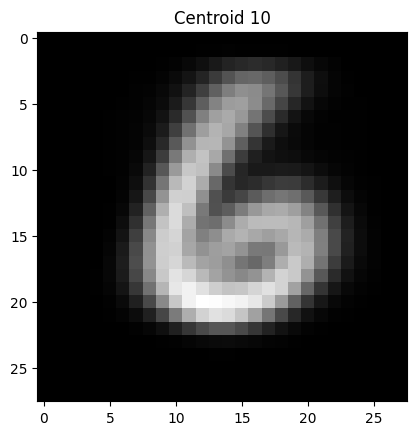

In [5]:
import time
import pyspark


if __name__ == "__main__":
    os.environ["PYSPARK_PYTHON"] = sys.executable
    os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

    execution_times = []
    speed_up = []


    for i in range(1,13):
        start_time = time.time()
        number_cores = i
        conf = (
            pyspark.SparkConf()
            .setMaster('local[{}]'.format(number_cores))
        )
        sc = pyspark.SparkContext(conf=conf)
        # read data
        data = parallelReadFile("../data/tot_mnist_shuf.csv")
        # optimize performance
        data_cache = data.cache()
        centroids = parallelKMeans(data_cache, 10, 10)
        plot_centroids(centroids)
        execution_times.append(time.time() - start_time)
        sc.stop()
    num_workers = list(range(1, len(execution_times)+1))


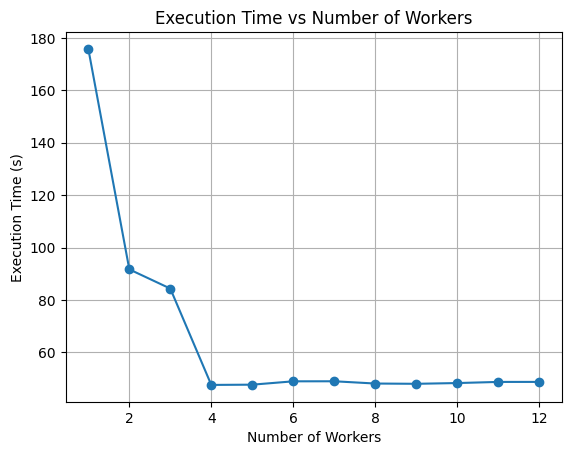

In [6]:
plt.plot(num_workers, execution_times, marker='o', linestyle='-')
plt.xlabel('Number of Workers')  # Label for x-axis
plt.ylabel('Execution Time (s)')  # Label for y-axis
plt.title('Execution Time vs Number of Workers')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()

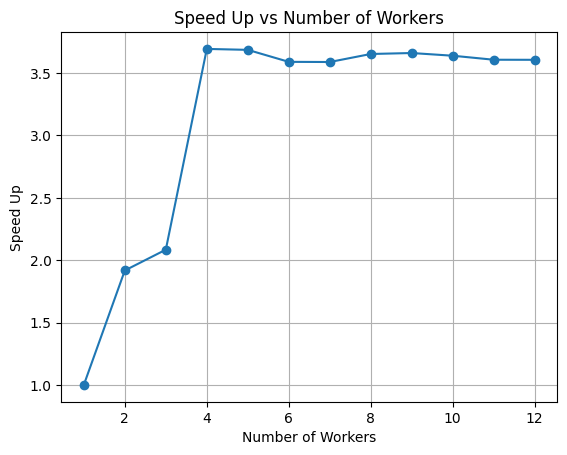

In [7]:
for i in range(0,len(execution_times)):
    speed_up.append(execution_times[0]/execution_times[i])
plt.plot(num_workers, speed_up, marker='o', linestyle='-')
plt.xlabel('Number of Workers')  # Label for x-axis
plt.ylabel('Speed Up')  # Label for y-axis
plt.title('Speed Up vs Number of Workers')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()

23/12/17 18:39:23 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


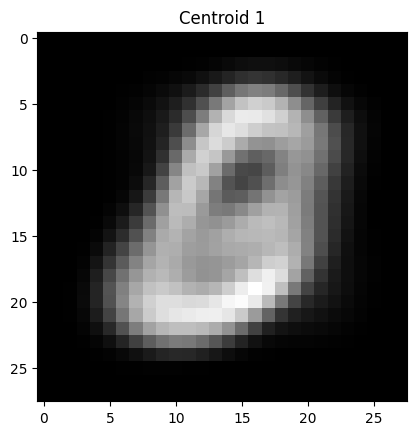

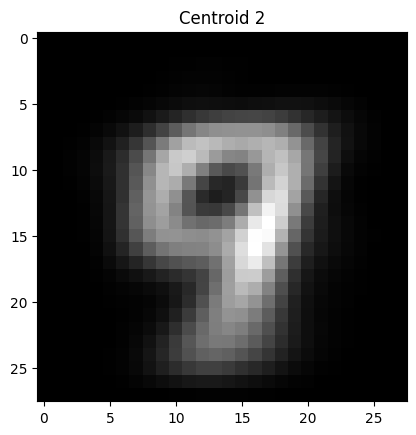

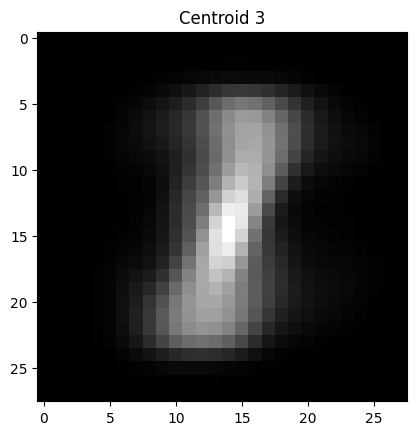

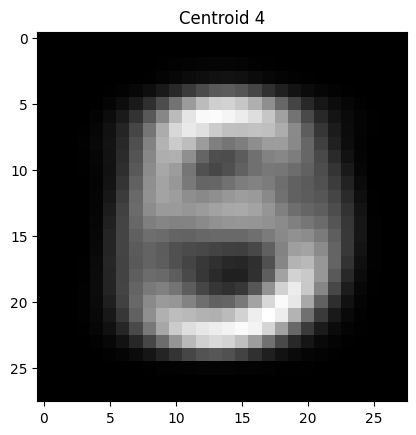

23/12/17 18:39:46 WARN BlockManager: Task 81 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


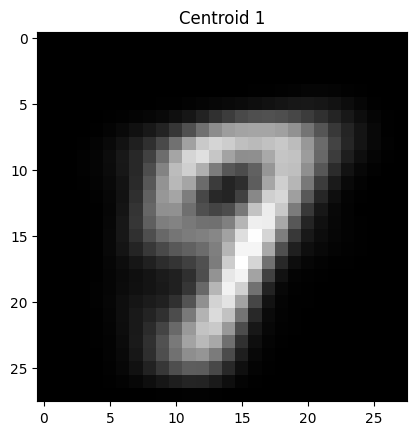

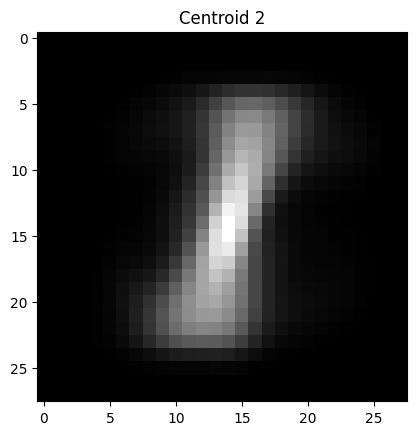

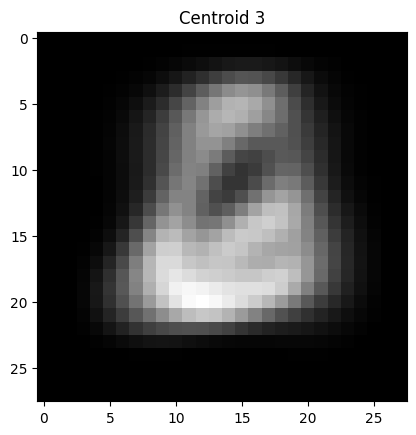

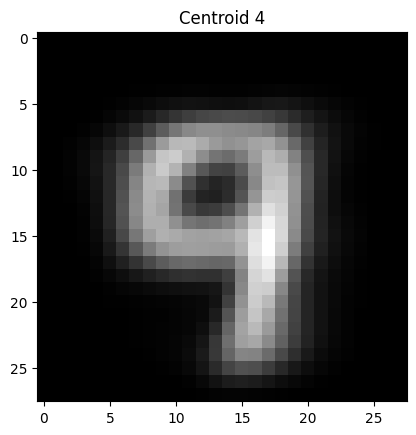

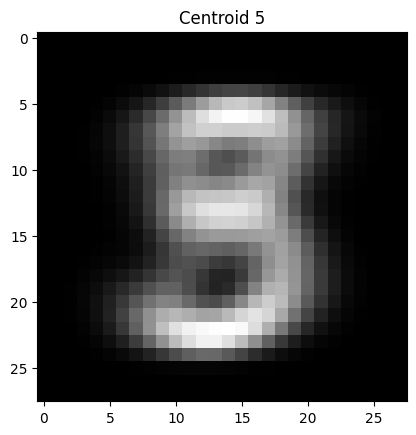

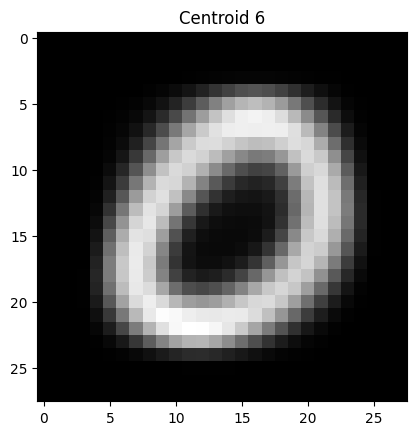

23/12/17 18:40:15 WARN BlockManager: Task 162 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


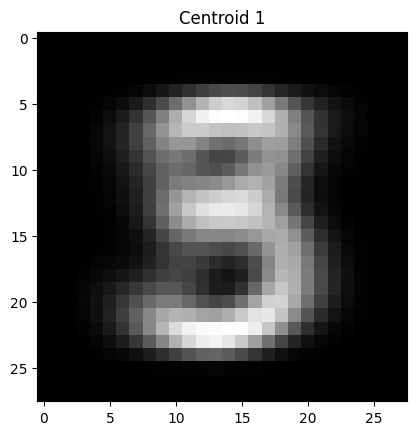

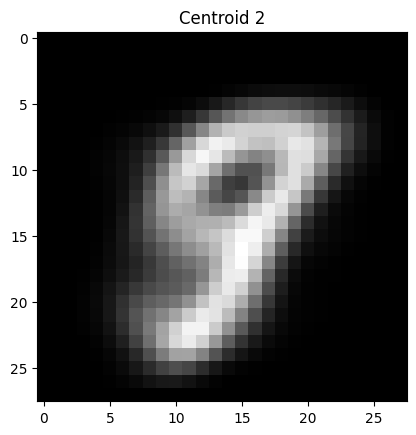

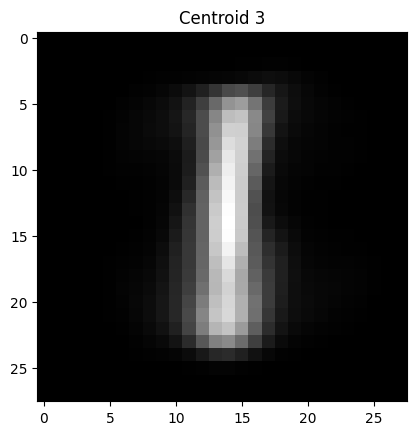

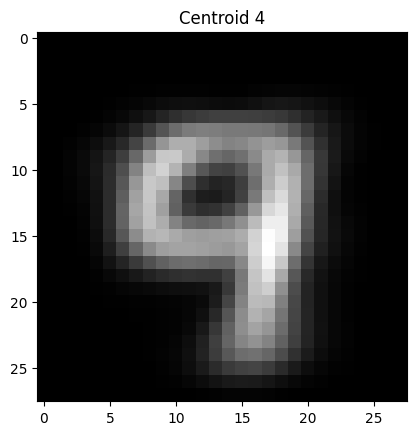

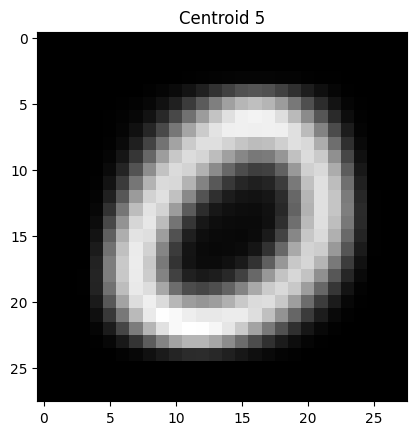

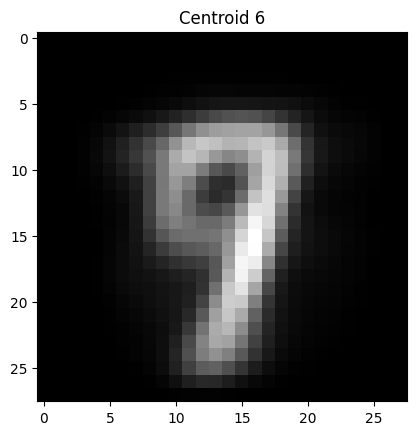

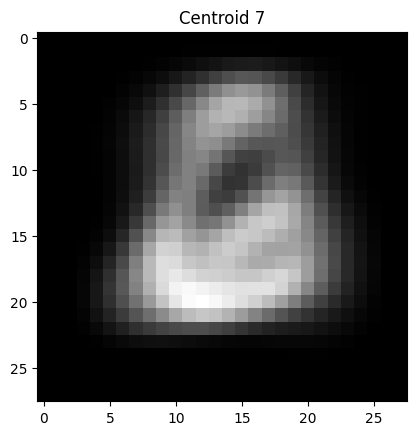

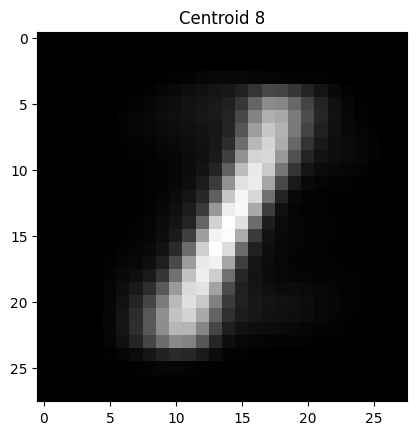

23/12/17 18:40:53 WARN BlockManager: Task 243 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


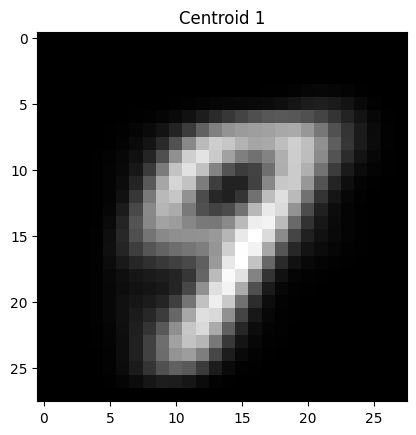

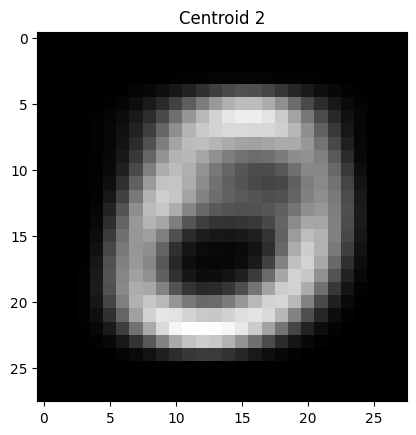

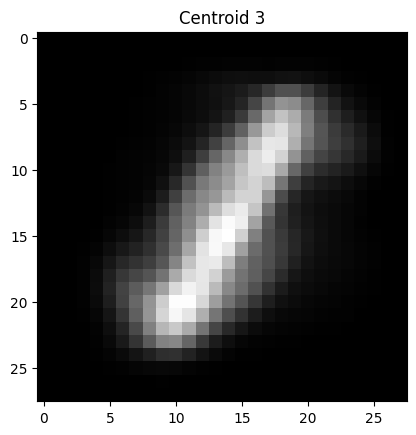

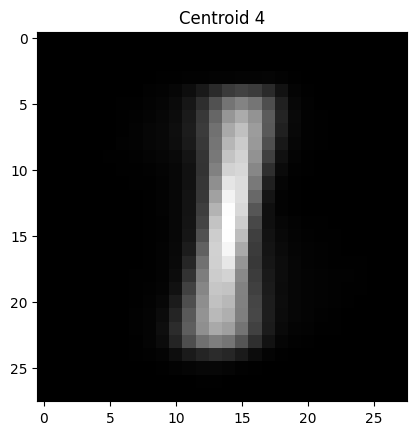

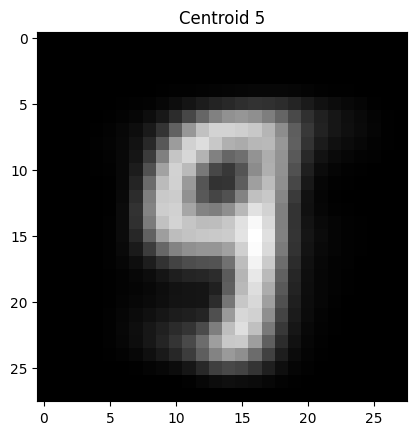

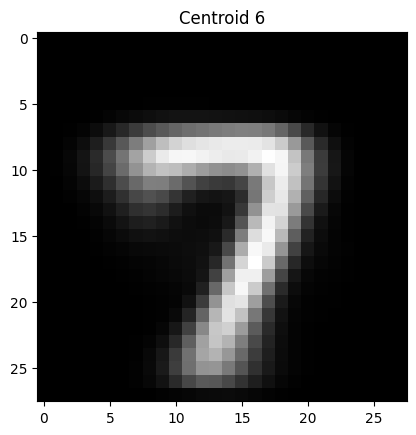

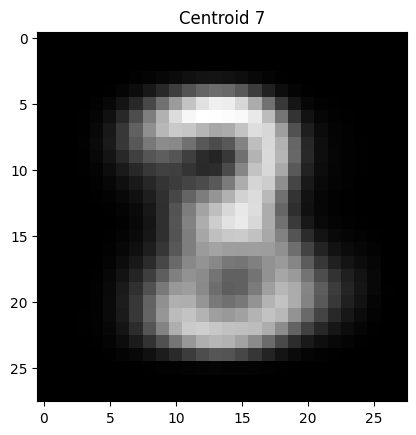

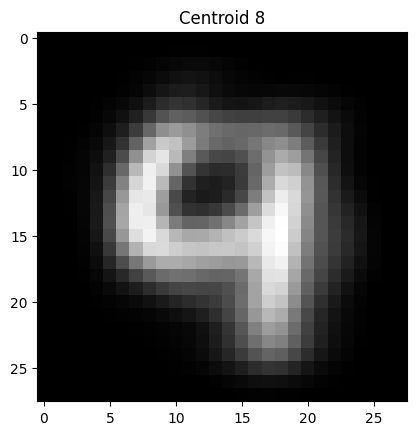

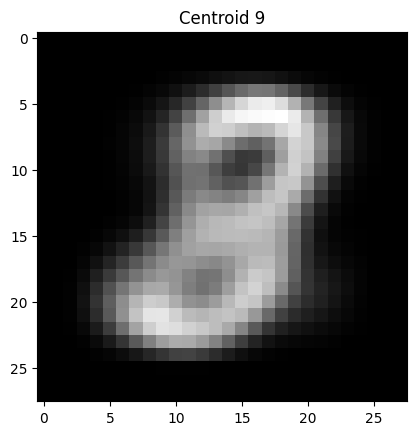

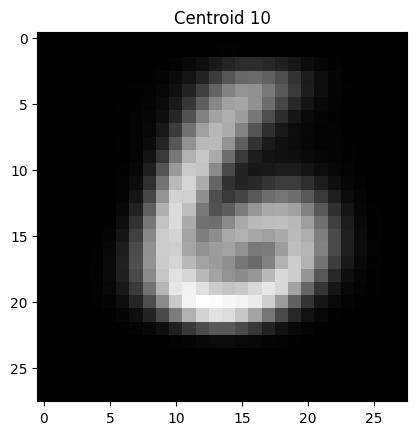

23/12/17 18:41:39 WARN BlockManager: Task 324 already completed, not releasing lock for rdd_2_0


Iteration:  0


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


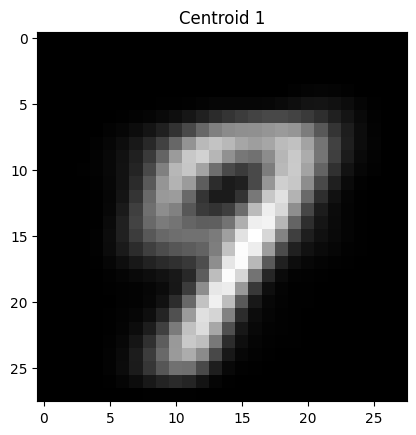

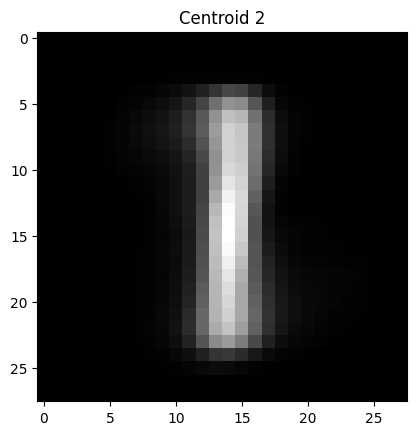

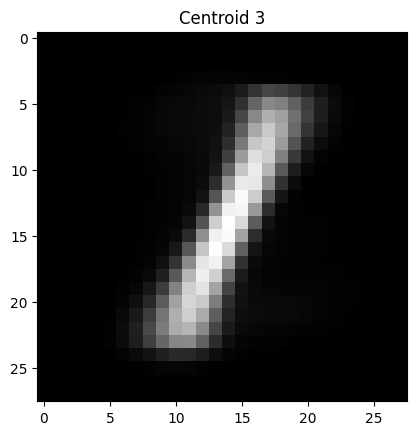

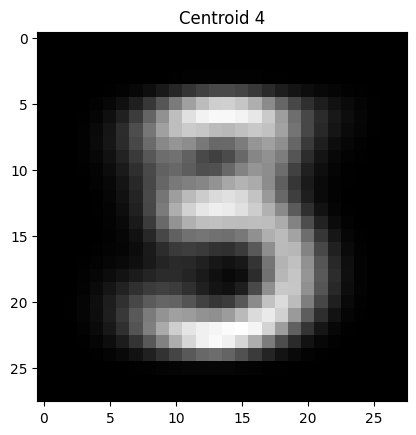

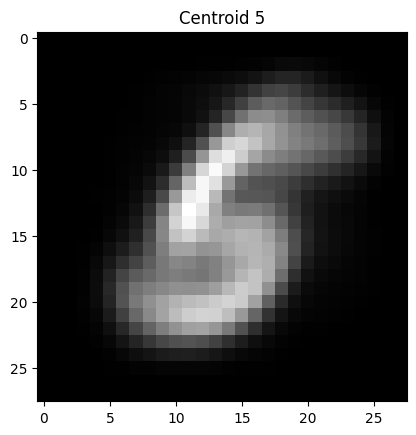

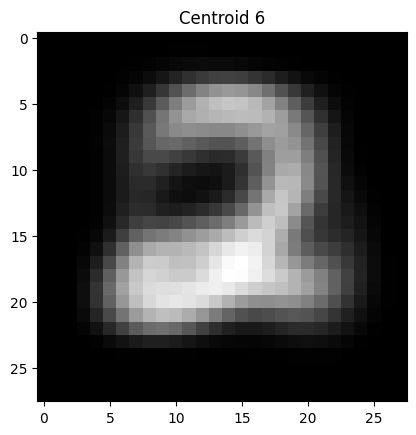

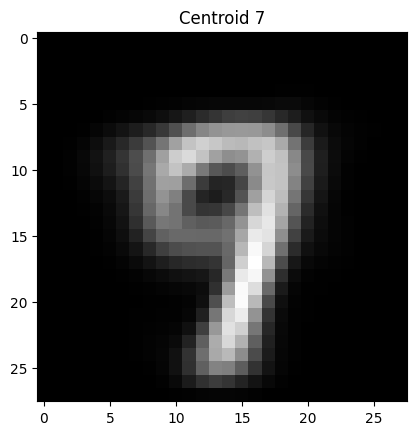

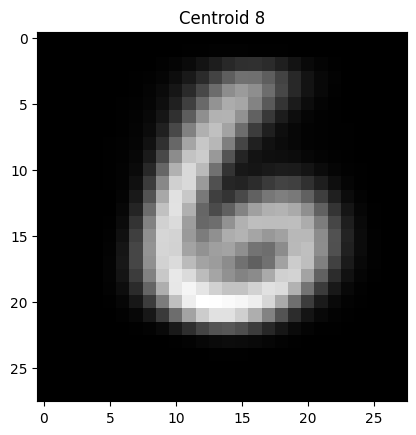

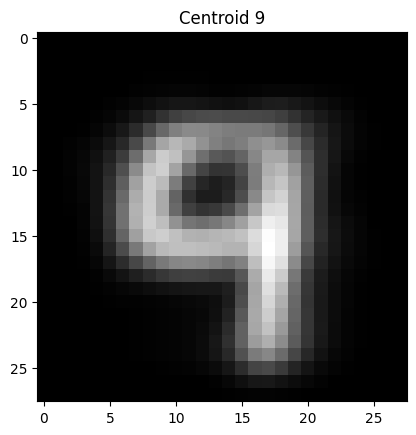

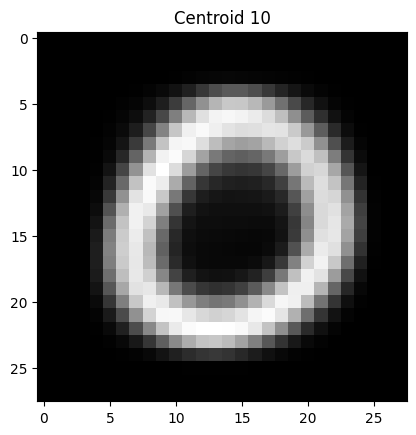

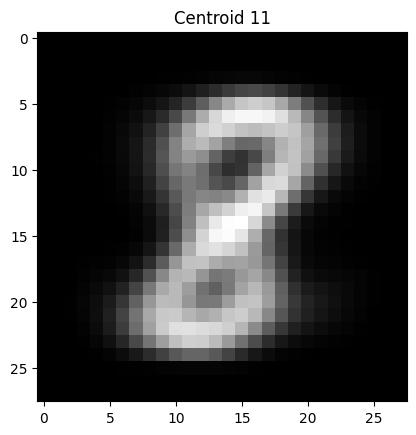

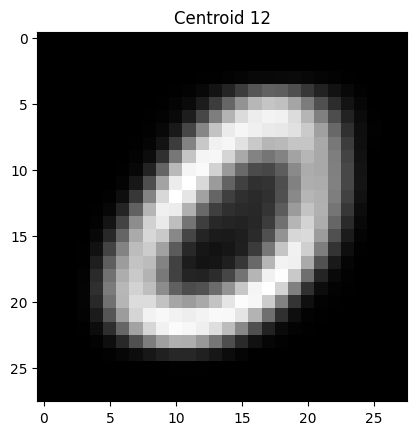

In [8]:
import time
import pyspark


if __name__ == "__main__":
    os.environ["PYSPARK_PYTHON"] = sys.executable
    os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

    execution_times = []
    speed_up = []
    
    # Set K values
    k_values = [4, 6, 8, 10, 12]  # Replace with the K values you want to test
    
    conf = (
        pyspark.SparkConf()
        .setMaster('local[{}]'.format(10))
    )
    sc = pyspark.SparkContext(conf=conf)
    # read data
    data = parallelReadFile("../data/tot_mnist_shuf.csv")
    # optimize performance
    data_cache = data.cache()
    for i in k_values:
        start_time = time.time()
        centroids = parallelKMeans(data_cache, i, 10)
        plot_centroids(centroids)
        execution_times.append(time.time() - start_time)


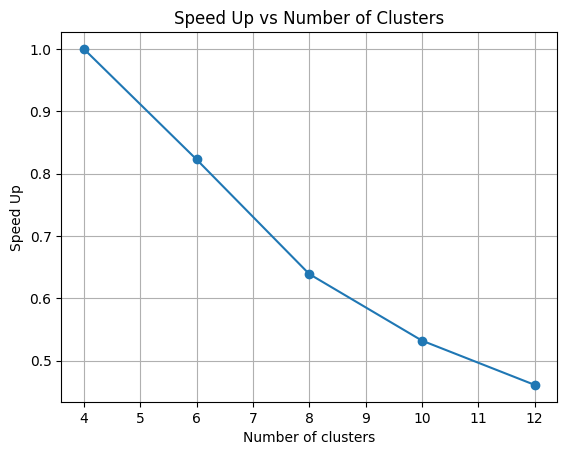

In [9]:
for i in range(0,len(execution_times)):
    speed_up.append(execution_times[0]/execution_times[i])
plt.plot(k_values, speed_up, marker='o', linestyle='-')
plt.xlabel('Number of clusters')  # Label for x-axis
plt.ylabel('Speed Up')  # Label for y-axis
plt.title('Speed Up vs Number of Clusters')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()